## Load dataset

In [2]:
import os
import pandas as pd

# Load the CSV file with the correct encoding and specify headers
file_path = 'texts_2024_1120_aggregate.csv'

# Define the headers
headers = ['fullname', 'Measures', 'Amount', 'Level', 'Function']  # Replace with your actual headers

df = pd.read_csv(file_path, encoding='latin1', names=headers, header=0)
df['filename'] = df['fullname'].str.split('/').str[-1]

# Extract type, id, and model
df[['type', 'id', 'model']] = df['filename'].str.extract(r'(\w+)_(\d+)@(\w+)')
#measures_to_compare = unique[1::5][:50]
filtered_measures = [measure for measure in df['Measures'] if 'par' not in measure.lower()]
print(filtered_measures[:15])
# Prepare DataFrames for comparison
df = df[df['Measures'].isin(filtered_measures)]
grouped2 = df.groupby(['type', 'model', 'Measures'])

filtered_measures2 = [measure for measure in df['Measures'] if '(Doc)' in measure]
#df = df[df['type'] == 'acad']

dfDoc = df[df['Measures'].isin(filtered_measures2)]
df = df.drop(columns=['Level','Function', 'fullname', 'filename'])
pivot_df = df.pivot(index=['id', 'model', 'type'], columns='Measures', values='Amount').reset_index()
print(pivot_df[:6])



['Letter count (Sent Avg)', 'Letter count (Sent SD)', 'Letter count (Sent Max)', 'Letter count (Sent Min)', 'Word count (Doc)', 'Word count (Sent Avg)', 'Word count (Sent SD)', 'Word count (Sent Max)', 'Word count (Sent Min)', 'Type count (Doc)', 'Type count (Sent Avg)', 'Type count (Sent SD)', 'Type count (Sent Max)', 'Type count (Sent Min)', 'Sentence count (Doc)']
Measures    id    model  type  Adjective avg position (Doc)  \
0         0007     Meta  acad                      0.496633   
1         0007     Meta   fic                      0.526100   
2         0007  chunk_1  acad                      0.350858   
3         0007  chunk_1   fic                      0.536830   
4         0007  chunk_2  acad                      0.373590   
5         0007  chunk_2   fic                      0.533355   

Measures  Adjective avg position (Sent Avg)  \
0                                  0.375528   
1                                  0.311252   
2                                  0.305196   


## Load predictable data

In [138]:

def parse_linguistic_data(data):
    lines = data.split('\n')
    headers = lines[0].split('\t')
    parsed_data = {header: [] for header in headers}
    
    skip_next = False

    for i, line in enumerate(lines[1:], start=1):
        if skip_next:
            skip_next = False
            continue

        values = line.split('\t')
        if any('par' in value.lower() for value in values):
            skip_next = True
            continue

        for header, value in zip(headers, values):
            parsed_data[header].append(value)
    
    return parsed_data


filehum = 'analysis-results(4).txt'
with open(filehum, 'r') as gpt_file:
    gpt_data = gpt_file.read()
gpt_parsed = parse_linguistic_data(gpt_data)

newX = pd.DataFrame([gpt_parsed['Text 1'][1:]], columns=gpt_parsed['Measures'][2:])
print(newX)

  Letter count (Sent Avg) Letter count (Sent SD) Letter count (Sent Max)  \
0                 2387.00                  64.51                   31.66   

  Letter count (Sent Min) Word count (Doc) Word count (Sent Avg)  \
0                  143.00            18.00                548.00   

  Word count (Sent SD) Word count (Sent Max) Word count (Sent Min)  \
0                14.81                  7.33                 31.00   

  Type count (Doc)  ... Levenshtein PoS dist. (Sent-Sent Min)  \
0             5.00  ...                                  0.92   

  Cosine dist. (Sent-Doc Avg) Cosine dist. (Sent-Doc SD)  \
0                        0.46                       0.70   

  Cosine dist. (Sent-Doc Max) Cosine dist. (Sent-Doc Min)  \
0                        0.13                        0.86   

  Cosine dist. (Sent-Sent Avg) Cosine dist. (Sent-Sent SD)  \
0                         0.35                        0.53   

  Cosine dist. (Sent-Sent Max) Cosine dist. (Sent-Sent Min)        
0

In [139]:
expected_features = rf_model.feature_names_in_  # Features used during fit

# Add missing columns with default values
for feature in expected_features:
    if feature not in newX.columns:
        newX[feature] = 0  # Default value (adjust as needed)
        print(feature)

# Ensure columns are in the correct order
newX = newX[expected_features]

y_pred3 = rf_model.predict(newX)
print(y_pred3)

Auxiliary-lexical verb ratio (Doc)
Hapax legomena count (Doc)
Letter count (Doc)
Pronoun avg position (Doc)
Pronoun burstiness (Doc)
Pronoun concentration (Doc)
Pronoun count (Doc)
Pronoun incidence (Doc)
Pronoun length (Doc)
Pronoun position SD (Doc)
Pronoun type count (Doc)
Pronoun type-token ratio (Doc)
Pronoun-grammatical item ratio (Doc)
Type-token ratio (Doc)
[ True]


## RandomForest

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Drop columns that are not features
X = pivot_df.drop(columns=['model', 'id', 'type'])
y = pivot_df['type']

# Impute missing values
imputer = SimpleImputer(strategy='mean')  # You can also use 'median', 'most_frequent', or 'constant'
X_imputed = imputer.fit_transform(X)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA
pca = PCA(n_components=0.5)  # Retain 50% of the variance
X_pca = pca.fit_transform(X_scaled)

# Initialize stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5)

# Iterate through the folds
for train_index, test_index in skf.split(X_pca, y):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train your model
    model = RandomForestClassifier(n_estimators=1, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

Accuracy: 0.775
              precision    recall  f1-score   support

        acad       0.79      0.75      0.77        40
         fic       0.76      0.80      0.78        40

    accuracy                           0.78        80
   macro avg       0.78      0.78      0.77        80
weighted avg       0.78      0.78      0.77        80

Accuracy: 0.75
              precision    recall  f1-score   support

        acad       0.79      0.68      0.73        40
         fic       0.72      0.82      0.77        40

    accuracy                           0.75        80
   macro avg       0.76      0.75      0.75        80
weighted avg       0.76      0.75      0.75        80

Accuracy: 0.75
              precision    recall  f1-score   support

        acad       0.70      0.88      0.78        40
         fic       0.83      0.62      0.71        40

    accuracy                           0.75        80
   macro avg       0.77      0.75      0.75        80
weighted avg       0.77     

#### skf split

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold

X = pivot_df.drop(columns=['model', 'id', 'type'])
y = pivot_df['model'].isin(['gpt', 'Meta'])
# Initialize stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5)

# Iterate through the folds
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train your model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

Accuracy: 0.95
              precision    recall  f1-score   support

       False       0.93      0.97      0.95        40
        True       0.97      0.93      0.95        40

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80

Accuracy: 0.9375
              precision    recall  f1-score   support

       False       0.91      0.97      0.94        40
        True       0.97      0.90      0.94        40

    accuracy                           0.94        80
   macro avg       0.94      0.94      0.94        80
weighted avg       0.94      0.94      0.94        80

Accuracy: 0.9125
              precision    recall  f1-score   support

       False       0.92      0.90      0.91        40
        True       0.90      0.93      0.91        40

    accuracy                           0.91        80
   macro avg       0.91      0.91      0.91        80
weighted avg       0.91  

In [ ]:
from sklearn.metrics import confusion_matrix

# Sample true labels and predicted labels
true_labels = y_test
predicted_labels = y_pred

# Generate the confusion matrix
#cm = confusion_matrix(true_labels, predicted_labels, labels=['Meta', 'chunk_1', 'chunk_2', 'gpt'])
cm = confusion_matrix(true_labels, predicted_labels, labels=['acad', 'fic'])
# Create a DataFrame from the confusion matrix
#cm_df = pd.DataFrame(cm, index=['Meta', 'chunk_1', 'chunk_2', 'gpt'], columns=['Meta', 'chunk_1', 'chunk_2', 'gpt'])
cm_df = pd.DataFrame(cm, index=['acad', 'fic'], columns=['acad', 'fic'])
# Add a column for the true labels
cm_df['True Label'] = cm_df.index

# Melt the DataFrame to get a long format
cm_melted = cm_df.melt(id_vars='True Label', var_name='Predicted Label', value_name='Count')

# Filter out the correct predictions
incorrect_predictions = cm_melted[cm_melted['True Label'] != cm_melted['Predicted Label']]

print("Confusion Matrix:")
print(cm_df)
print("\nIncorrect Predictions:")
print(incorrect_predictions)



Confusion Matrix:
      acad  fic True Label
acad    32    8       acad
fic      6   34        fic

Incorrect Predictions:
  True Label Predicted Label  Count
1        fic            acad      6
2       acad             fic      8

Indices of Incorrect Predictions:


KeyError: 0

In [8]:
print(y_test)
print(X_test)

320    acad
321     fic
322    acad
323     fic
324    acad
       ... 
395     fic
396    acad
397     fic
398    acad
399     fic
Name: type, Length: 80, dtype: object
[[ 6.89282889e+00 -3.41296902e+00 -3.43318479e+00  1.58756066e+00
   2.50946742e+00 -6.31699371e+00 -1.96251761e+00 -6.78399567e-01
   1.73541853e+00 -4.75782140e+00 -2.72440529e+00]
 [-2.08738725e+01 -8.72146820e+00 -1.37795928e+00 -1.13334582e+00
   6.66780470e+00  5.25627754e+00  2.66174930e+00  1.46904462e+00
   3.55350901e+00  2.10363858e-01 -2.31995889e+00]
 [ 1.92636145e+01 -4.22092396e+00  1.69474440e+01  3.01049477e+00
   6.69128609e-01 -3.82563610e+00  2.55362318e+00  2.52829907e+00
   2.01096869e+00  8.33525510e+00 -2.66703949e+00]
 [-2.94710380e+01 -4.36439026e+00  4.27831908e+00 -2.91901356e-01
   7.20651314e-01  8.31005569e+00 -1.16560271e+00  3.92197573e+00
  -2.65939104e+00  3.60751192e+00 -4.54032515e+00]
 [ 1.27194382e+01  4.23596662e+00  9.09626294e+00  5.89657545e+00
   3.58225874e-02 -2.94285945e-0

In [ ]:
chunk_1_mean_features = mean_features[mean_features['model'] == 'chunk_1']

# Print the results
print(chunk_1_mean_features)

KeyError: 'model'

## Feature Importance

                                         Feature  Importance
1106            PoS overlap count (Sent-Doc Max)    0.030621
751            Lemma overlap count (Sent-Doc SD)    0.026217
749           Lemma overlap count (Sent-Doc Max)    0.022917
1383                            Type count (Doc)    0.022344
562                   Hapax legomena count (Doc)    0.021988
1517           Word overlap count (Sent-Doc Max)    0.019182
1501                            Word count (Doc)    0.017502
793        Levenshtein lemma dist. (Sent-Doc SD)    0.017473
784   Levenshtein character dist. (Sent-Doc Min)    0.017308
768                       Letter count (Sent SD)    0.016958
785    Levenshtein character dist. (Sent-Doc SD)    0.016757
1521          Word overlap count (Sent-Sent Max)    0.016118
567               Hapax legomena incidence (Doc)    0.014513
1320                   Sentence length (Sent SD)    0.013596
1503                       Word count (Sent Max)    0.012872
837                Lexic

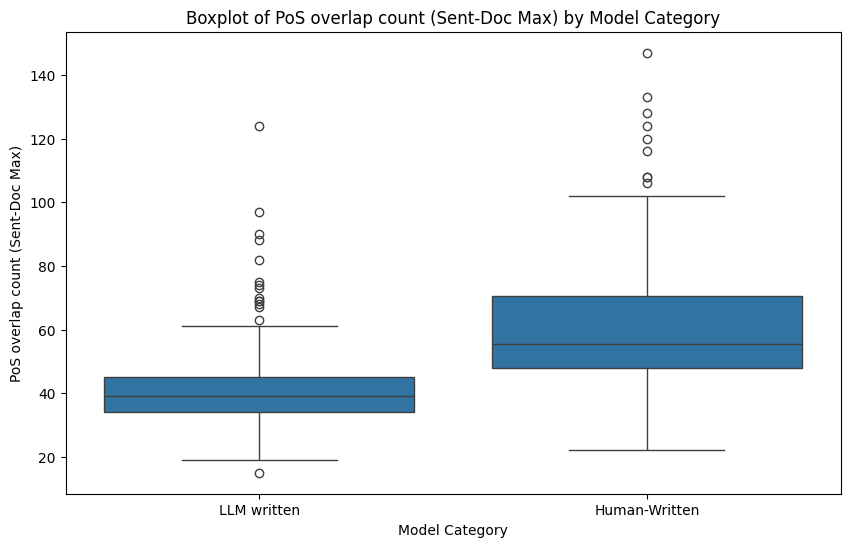

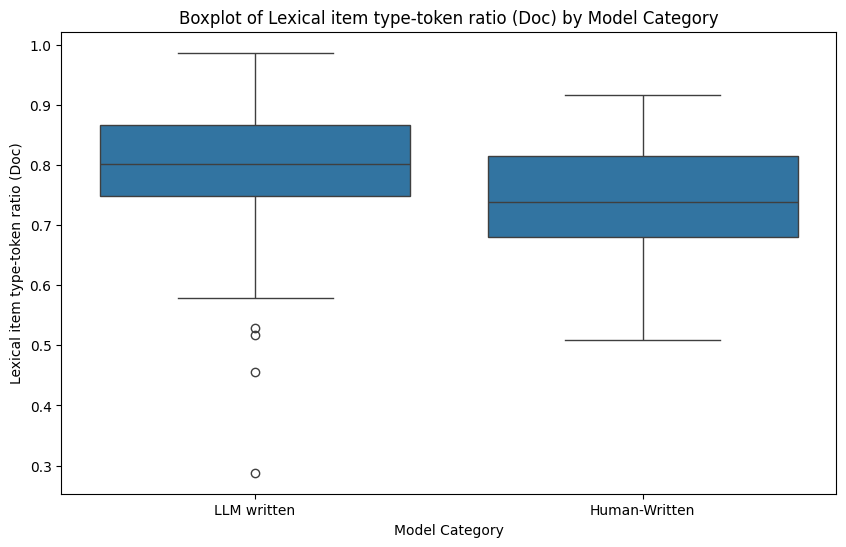

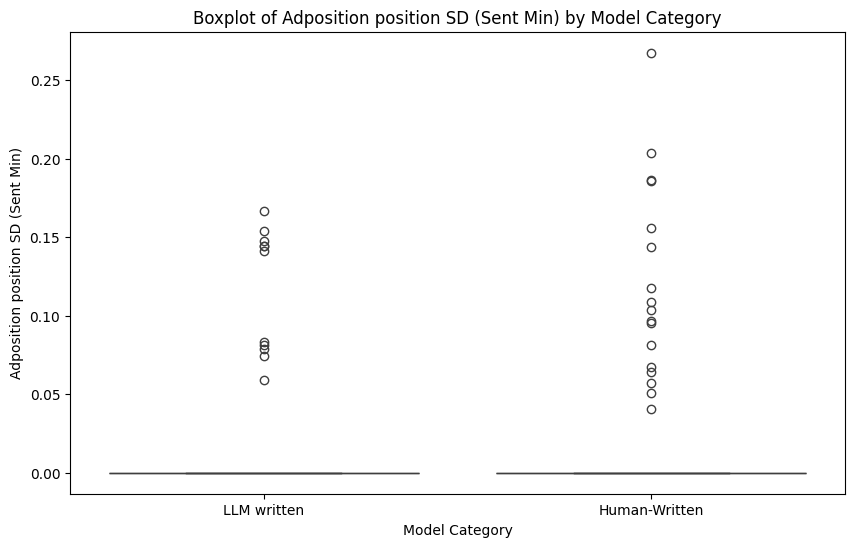

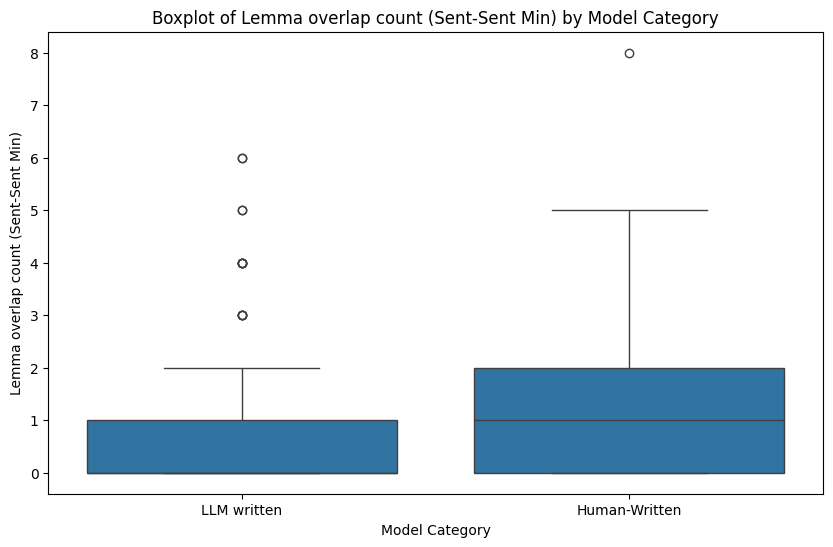

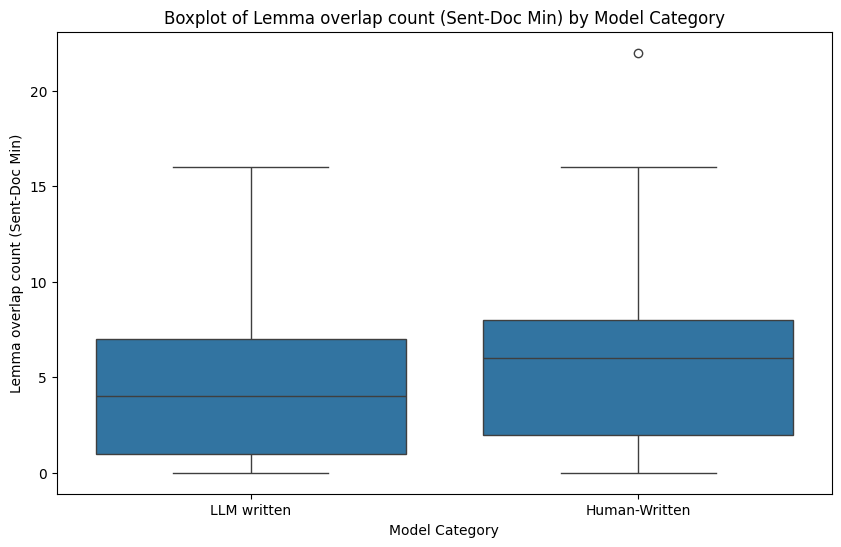

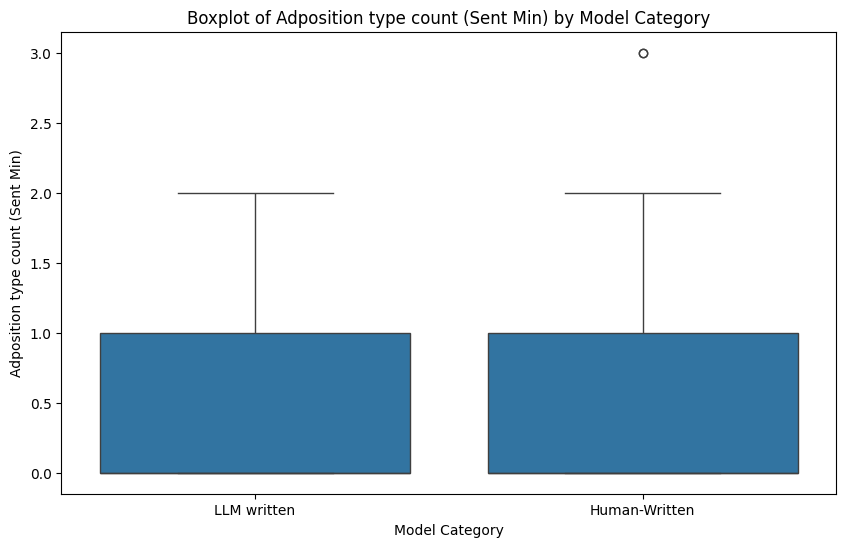

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Get feature importances
importances = rf_model.feature_importances_

# Combine with feature names
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances[:20])

def plot_boxplots(pivot_df, col):
    # Create a new column to categorize the models
    pivot_df['Model Category'] = pivot_df['model'].apply(lambda x: 'LLM written' if x in ['gpt', 'Meta'] else 'Human-Written')

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Model Category', y=col, data=pivot_df)
    
    # Add title and labels
    plt.title('Boxplot of ' + col + ' by Model Category')
    plt.xlabel('Model Category')
    plt.ylabel(col)
    
    # Show the plot
    plt.show()

# Example usage
for i in range(0, 1):
    val = feature_importances[i:i+1]['Feature'].values[0]
    plot_boxplots(pivot_df, val)
    
for i in range(0, 5):
    val = feature_importances[len(feature_importances)-i - 1:len(feature_importances)-i]['Feature'].values[0]
    plot_boxplots(pivot_df, val)
